In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from eztao.carma import DRW_term
from eztao.ts import addNoise, gpSimRand

mpl.rcParams.update(
    {
        "text.usetex": True,
        "axes.labelsize": 20,
        "figure.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "figure.constrained_layout.wspace": 0,
        "figure.constrained_layout.hspace": 0,
        "figure.constrained_layout.h_pad": 0,
        "figure.constrained_layout.w_pad": 0,
        "axes.linewidth": 1.3,
    }
)

import jax
import jax.numpy as jnp

# you should always set this
jax.config.update("jax_enable_x64", True)

## Damped Random Walk (DRW) Fitting

### 1. Light Curve Simulation

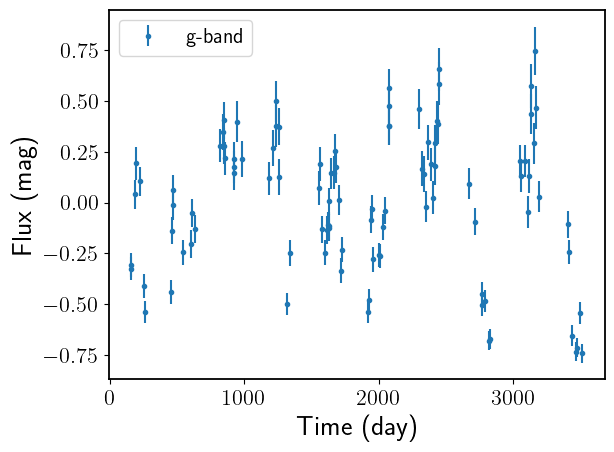

In [2]:
amps = {"g": 0.35}
taus = {"g": 100}
snrs = {"g": 5}  # ratio of the DRW amplitude to the median error bar
sampling_seeds = {"g": 2}  # seed for random sampling
noise_seeds = {"g": 11}  # seed for mocking observational noise

ts, ys, yerrs = {}, {}, {}
ys_noisy = {}
seed = 1
for band in "g":
    DRW_kernel = DRW_term(np.log(amps[band]), np.log(taus[band]))
    t, y, yerr = gpSimRand(
        DRW_kernel,
        snrs[band],
        365 * 10,  # 10 year LC
        100,
        lc_seed=seed,
        downsample_seed=sampling_seeds[band],
    )

    # add to dict
    ts[band] = t
    ys[band] = y
    yerrs[band] = yerr
    # add simulated photometric noise
    ys_noisy[band] = addNoise(ys[band], yerrs[band], seed=noise_seeds[band] + seed)

for b in "g":
    plt.errorbar(
        ts[b][::1], ys_noisy[b][::1], yerrs[b][::1], fmt=".", label=f"{b}-band"
    )

plt.xlabel("Time (day)")
plt.ylabel("Flux (mag)")
plt.legend(fontsize=15)

### 2. Fitting
Here, we demonstrate how to use the `UniVarModel` for fitting single-band light curves.

In [3]:
import numpyro
import numpyro.distributions as dist
from eztaox.fitter import random_search
from eztaox.kernels.quasisep import Exp
from eztaox.models import UniVarModel
from numpyro.handlers import seed as numpyro_seed

#### 2.1 Initialize Light Curve Model

In [4]:
zero_mean = False

# initialize a GP kernel, note the initial parameters are not used in the fitting
k = Exp(scale=100.0, sigma=1.0)
m = UniVarModel(ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean)
m

UniVarModel(
  X=(f64[100], i64[100]),
  y=f64[100],
  diag=f64[100],
  base_kernel_def=<jax._src.util.HashablePartial object at 0xffff1fd1bda0>,
  multiband_kernel=<class 'eztaox.kernels.quasisep.MultibandLowRank'>,
  nBand=1,
  mean_func=None,
  amp_scale_func=None,
  lag_func=None,
  zero_mean=False,
  has_jitter=False,
  has_lag=False
)

#### 2.2 Define InitSampler

In [5]:
def initSampler():
    # GP kernel param
    log_drw_scale = numpyro.sample(
        "drw_scale", dist.Uniform(jnp.log(0.01), jnp.log(1000))
    )
    log_drw_sigma = numpyro.sample(
        "drw_sigma", dist.Uniform(jnp.log(0.01), jnp.log(10))
    )
    log_kernel_param = jnp.stack([log_drw_scale, log_drw_sigma])
    numpyro.deterministic("log_kernel_param", log_kernel_param)

    # mean
    mean = numpyro.sample("mean", dist.Uniform(low=-0.2, high=0.2))

    sample_params = {"log_kernel_param": log_kernel_param, "mean": mean}
    return sample_params

In [6]:
# generate a random initial guess
sample_key = jax.random.PRNGKey(1)
prior_sample = numpyro_seed(initSampler, rng_seed=sample_key)()
prior_sample

{'log_kernel_param': Array([-2.19138685,  0.3506587 ], dtype=float64),
 'mean': Array(-0.06222013, dtype=float64)}

#### 2.3 MLE Fitting

In [7]:
%%time
model = m
sampler = initSampler
fit_key = jax.random.PRNGKey(1)
nSample = 10_000
nBest = 10  # it seems like this number needs to be high

bestP, ll = random_search(model, initSampler, fit_key, nSample, nBest)
bestP

CPU times: user 881 ms, sys: 35.3 ms, total: 917 ms
Wall time: 890 ms


{'log_kernel_param': Array([ 4.47505521, -1.06045561], dtype=float64),
 'mean': Array(-0.0543972, dtype=float64)}

In [8]:
print("True DRW Params (in natual log):")
print(np.log(np.hstack([taus["g"], amps["g"]])))
print("MLE DHO Params (in natual log):")
print(bestP["log_kernel_param"])

True DRW Params (in natual log):
[ 4.60517019 -1.04982212]
MLE DHO Params (in natual log):
[ 4.47505521 -1.06045561]


### 3. MCMC

In [9]:
import arviz as az
from numpyro.infer import MCMC, NUTS, init_to_median

In [10]:
def numpyro_model(t, yerr, y=None):
    # GP kernel param
    log_drw_scale = numpyro.sample(
        "log_drw_scale", dist.Uniform(jnp.log(0.01), jnp.log(1000))
    )
    log_drw_sigma = numpyro.sample(
        "log_drw_sigma", dist.Uniform(jnp.log(0.01), jnp.log(10))
    )
    log_kernel_param = jnp.stack([log_drw_scale, log_drw_sigma])
    numpyro.deterministic("log_kernel_param", log_kernel_param)

    # mean: use a normal prior for better convergence
    mean = numpyro.sample("mean", dist.Normal(0.0, 0.1))

    sample_params = {"log_kernel_param": log_kernel_param, "mean": mean}

    # the following is different from the initSampler
    zero_mean = False

    k = Exp(scale=100.0, sigma=1.0)  # init params for k are not used
    m = UniVarModel(ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean)
    m.sample(sample_params)

In [11]:
%%time
nuts_kernel = NUTS(
    numpyro_model,
    dense_mass=True,
    target_accept_prob=0.9,
    init_strategy=init_to_median,
)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=1,
    # progress_bar=False,
)

mcmc_seed = 0
mcmc.run(jax.random.PRNGKey(mcmc_seed), ts["g"], yerrs["g"], y=ys_noisy["g"])
data = az.from_numpyro(mcmc)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:01<00:00, 3546.31it/s, 7 steps of size 5.01e-01. acc. prob=0.93] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  log_drw_scale      4.65      0.43      4.61      3.97      5.31   2806.32      1.00
  log_drw_sigma     -0.98      0.18     -1.00     -1.26     -0.71   2456.68      1.00
           mean     -0.03      0.07     -0.03     -0.15      0.08   3658.74      1.00

Number of divergences: 0
CPU times: user 3.34 s, sys: 77.6 ms, total: 3.41 s
Wall time: 3.38 s


#### Visualize Chains, Posterior Distributions

In [12]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

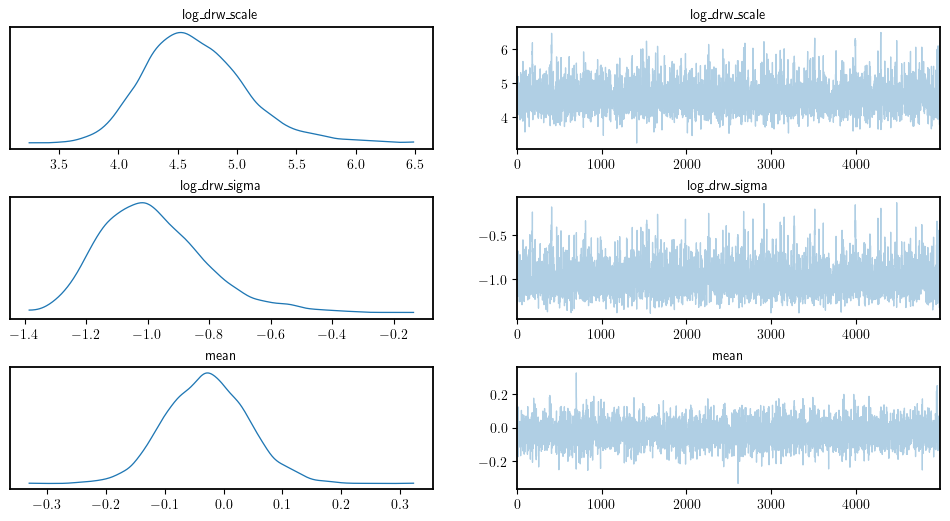

In [13]:
az.plot_trace(data, var_names=["log_drw_scale", "log_drw_sigma", "mean"])
plt.subplots_adjust(hspace=0.4)

array([[<Axes: ylabel='log_drw_sigma'>, <Axes: >],
       [<Axes: xlabel='log_drw_scale', ylabel='mean'>,
        <Axes: xlabel='log_drw_sigma'>]], dtype=object)

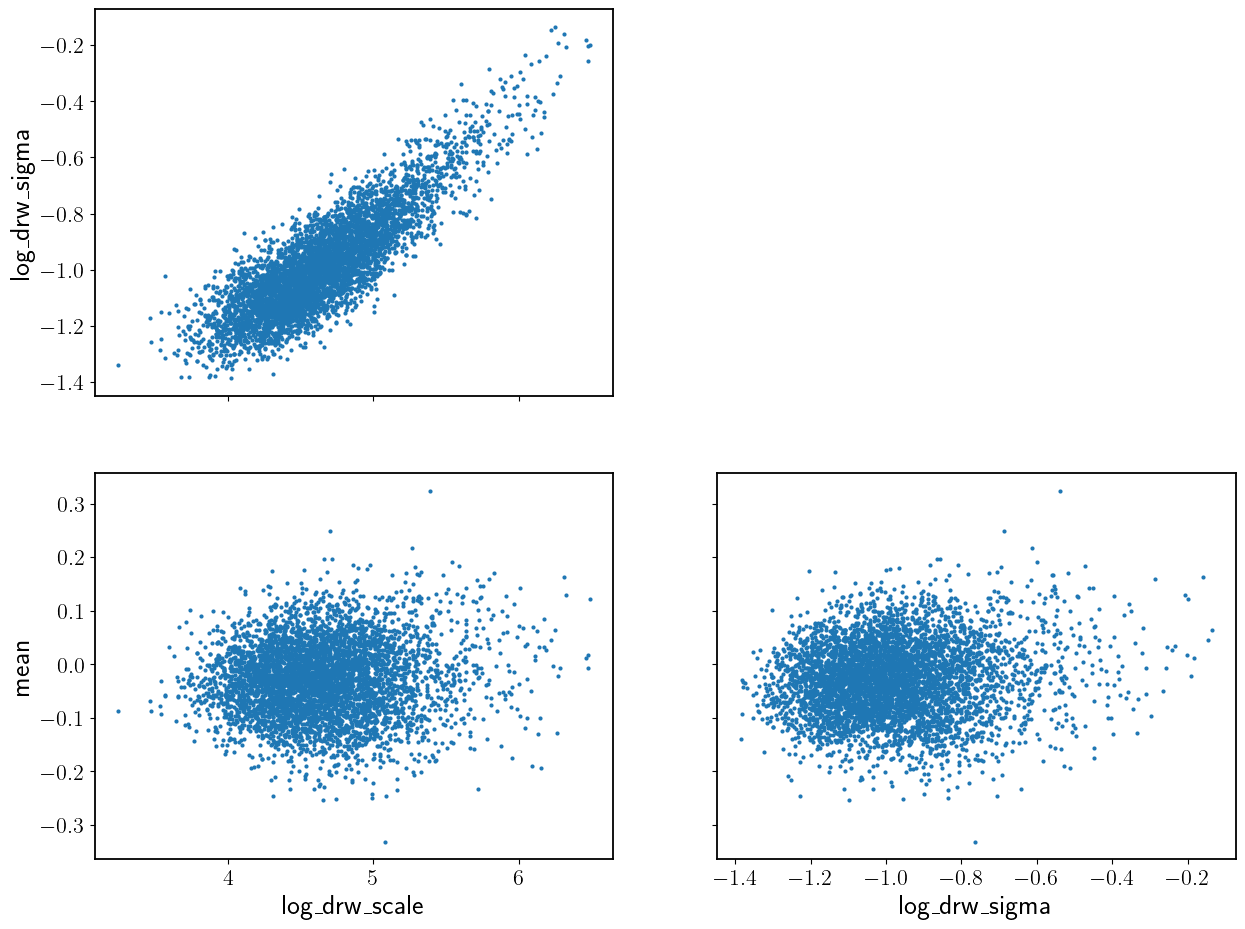

In [14]:
az.plot_pair(data, var_names=["log_drw_scale", "log_drw_sigma", "mean"])

### 4. Second-order Statistics

In [15]:
from eztaox.kernel_stat2 import gpStat2

ts = np.logspace(0, 4)
fs = np.logspace(-4, 0)

In [16]:
# get MCMC samples
flatPost = data.posterior.stack(sample=["chain", "draw"])
log_drw_draws = flatPost["log_kernel_param"].values.T

In [17]:
# create second-order stat object
drw_k = Exp(scale=taus["g"], sigma=amps["g"])
gpStat2_drw = gpStat2(drw_k)

#### 4.1 Structure Function

In [18]:
# compute sf for MCMC draws
mcmc_sf = jax.vmap(gpStat2_drw.sf, in_axes=(None, 0))(ts, jnp.exp(log_drw_draws))

Text(0, 0.5, 'SF')

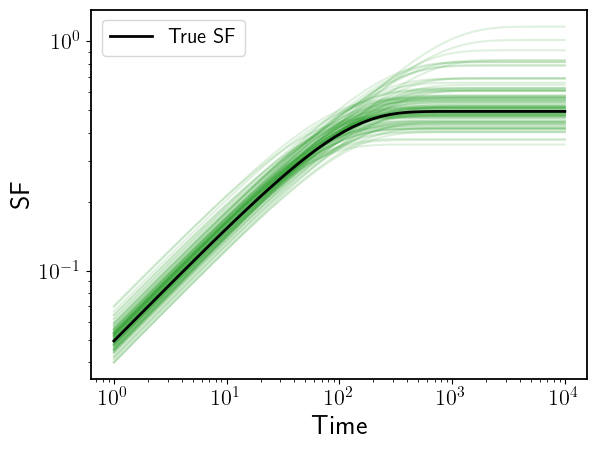

In [19]:
## plot
# ture SF
plt.loglog(ts, gpStat2_drw.sf(ts), c="k", label="True SF", zorder=100, lw=2)
plt.legend(fontsize=15)
# MCMC SFs
for sf in mcmc_sf[::50]:
    plt.loglog(ts, sf, c="tab:green", alpha=0.15)

plt.xlabel("Time")
plt.ylabel("SF")

#### 4.1 Power Spectral Density (PSD)

In [20]:
# compute sf for MCMC draws
mcmc_psd = jax.vmap(gpStat2_drw.psd, in_axes=(None, 0))(fs, jnp.exp(log_drw_draws))

Text(0, 0.5, 'PSD')

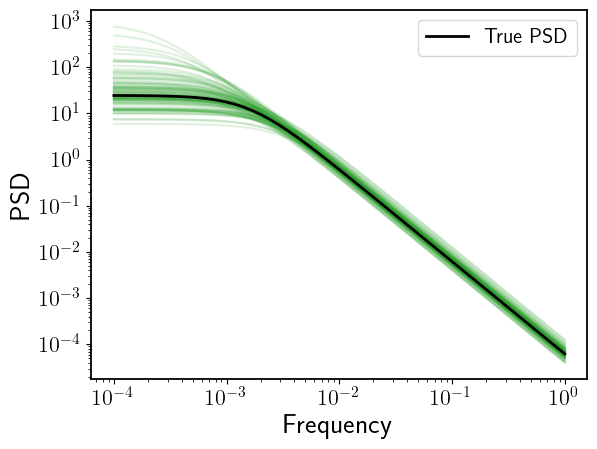

In [21]:
## plot
# ture PSD
plt.loglog(fs, gpStat2_drw.psd(fs), c="k", label="True PSD", zorder=100, lw=2)
plt.legend(fontsize=15)

# MCMC PSDs
for psd in mcmc_psd[::50]:
    plt.loglog(fs, psd, c="tab:green", alpha=0.15)

plt.xlabel("Frequency")
plt.ylabel("PSD")